<img src="https://www.mlflow.org/docs/latest/_static/MLflow-logo-final-black.png" width="200"> <b>

#### End to End Mlflow usage example

The goal is demonstrate how to use mlflow different functionalities.

**What we will do (core principles):**

1. Train and track a Randomforest model on version v5 on 'dvc' (using autolog. You can use whatever git tag you have given to your data version)
2. Register the model. (Will explain how to do in UI)
3. Load and inference particular version of model
4. Create a second model version using Xgboost on v5 on 'dvc' (using manual log. You can use whatever git tag you have given to your data version.)
5. Update the register Random Forest model version to Xbooost version. (This time we will do it manually)

In [13]:
import os
import warnings
import sys
import regex as re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,)
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import mlflow.sklearn
import logging
from pprint import pprint
from pathlib import Path
import dvc.api

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [14]:
warnings.filterwarnings("ignore")
np.random.seed(40)

### Get the particular Data version using DVC API


In [18]:
path = 'data\processed\data.csv'
repo = Path(os.getcwd()).parent.parent
version = "v5"

In [19]:
data_url = dvc.api.get_url(path=path,repo=repo,rev=version)
print(data_url)

gdrive://1bsoNT0rQycXZr0p39AlFtq2rrvfSWgdK/52/c4a565124626592e08742d0c165f89


In [20]:
with dvc.api.open(path=path,repo=repo,rev=version) as f:
    data = pd.read_csv(f)

In [21]:
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [22]:
data.shape

(891, 9)

In [23]:
X = data.drop(['Survived'], axis=1)
y = data['Survived']

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=2)


### Boilerplate code for getting Autolog tracked data

In [30]:
'''
Function for GettinG all the logged data information by mlflow.
'''
def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

### Autolog Data

In [31]:
mlflow.get_tracking_uri()

'sqlite:///mlruns.db'

In [32]:
# Use sqlite:///mlruns.db as the local store for tracking and registery
mlflow.set_tracking_uri("sqlite:///mlruns.db")

In [33]:
n_estimators=150
criterion="gini"
max_depth=10
rf = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,max_depth=max_depth)

with mlflow.start_run() as run:

    # Since DVC uri won't be autologged so logging seperately

    mlflow.log_param("Data Url",data_url)


    mlflow.sklearn.autolog(log_models=True)

    rf.fit(X_train,Y_train) # logging performance about train dataset
    
    mlflow.sklearn.eval_and_log_metrics(rf,X_test,Y_test,prefix="eval_") # logging performance about evaluation dataset

    params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)
    
    print(metrics)

    print(params)
    print("completed tracking")

{'training_precision_score': 0.8757579482137003, 'training_recall_score': 0.875, 'training_f1_score': 0.87274422317728, 'training_accuracy_score': 0.875, 'training_log_loss': 0.287255988063176, 'training_roc_auc_score': 0.9395445730690085, 'training_score': 0.875, 'eval_precision_score': 0.8219392103020547, 'eval_recall_score': 0.8100558659217877, 'eval_f1_score': 0.8049256225112432, 'eval_accuracy_score': 0.8100558659217877, 'eval_log_loss': 0.6669602251375639, 'eval_roc_auc_score': 0.8612658227848101, 'eval_score': 0.8100558659217877}
{'Data Url': 'gdrive://1bsoNT0rQycXZr0p39AlFtq2rrvfSWgdK/52/c4a565124626592e08742d0c165f89', 'bootstrap': 'True', 'ccp_alpha': '0.0', 'class_weight': 'None', 'criterion': 'gini', 'max_depth': '10', 'max_features': 'auto', 'max_leaf_nodes': 'None', 'max_samples': 'None', 'min_impurity_decrease': '0.0', 'min_samples_leaf': '1', 'min_samples_split': '2', 'min_weight_fraction_leaf': '0.0', 'n_estimators': '150', 'n_jobs': 'None', 'oob_score': 'False', 'rand

In [34]:
print(artifacts)

['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/requirements.txt']


### Model reistry and version tracking

We can register a model using following ways

* Using UI
* Using inbuilt model registry API

In [37]:
mlflow.get_tracking_uri()

'sqlite:///mlruns.db'

### Mlflow UI

Run following command from terminal for starting mlflow ui from terminal.

```
cd notebooks/mlflow/

mlflow ui --backend-store-uri sqlite:///mlruns.db

```

The visit http://localhost:5000/ link in your web browser.

### Create a new Registered Model

1. First, navigate to the MLflow Runs Sidebar by clicking the `Runs` icon in the Databricks Notebook UI.


2. Next, locate the MLflow Run corresponding to the Keras model training session, and open it in the MLflow Run UI by clicking the `View Run Detail` icon.

3. In the MLflow UI, scroll down to the `Artifacts` section and click on the directory named `model`. Click on the `Register Model` button that appears.

4. Then, select `Create New Model` from the drop-down menu, and input the following model name: `Titanic_model`. Finally, click `Register`. This registers a new model called `Titanic_model` and creates a new model version: `Version 1`.

After a few moments, the MLflow UI displays a link to the new registered model. Follow this link to open the new model version in the MLflow Model Registry UI.

### Explore the Model Registry UI Workflow

1. The Model Version page in the MLflow Model Registry UI provides information about `Version 1` of the registered titanic model, including its author, creation time, and its current stage.

2. The Model Version page also provides a `Source Run` link, which opens the MLflow Run that was used to create the model in the MLflow Run UI. From the MLflow Run UI, you can access the `Source Notebook Link` to view a snapshot of the Databricks Notebook that was used to train the model.

To navigate back to the MLflow Model Registry, click the `Models` icon in the Databricks Workspace Sidebar. The resulting MLflow Model Registry home page displays a list of all the registered models in your local Workspace, including their versions and stages.

Select the `Titanic_model` link to open the Registered Model page, which displays all of the versions of the Titanic model.

### Add model descriptions

Add a high-level description to the registered power forecasting model by clicking the `Edit Description` icon, entering the following description, and clicking `Save`:

```
Model to predict survival of passenger in Titanic ship

```

### Load versions of the registered model

You can load a model by specifying its name (e.g., `Titanic_model`) and version number (e.g., `1`). The following cell uses the `mlflow.pyfunc.load_model()` API to load `Version 1` of the registered power forecasting model as a generic Python function.

In [38]:
import mlflow.pyfunc
model_name = "Titanic_model"
model_version_uri = "models:/{model_name}/1".format(model_name=model_name)
print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
model_version_1 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/Titanic_model/1'


### Generate predictions with the Version 1 model


In [39]:
results = model_version_1.predict(pd.DataFrame(X_test))
accuracy  = accuracy_score(Y_test,results)
print("Accuracy Obtained in production:",accuracy
)

Accuracy Obtained in production: 0.8100558659217877


### Use XGBoost to create and register the second model

<img src="https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png"  width="200">

In [43]:
from xgboost import XGBClassifier

n_estimators = 10
max_depth = 5
learning_rate = 0.2
colsample_bytree = 0.8
gamma = 10

xgb = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,
learning_rate=learning_rate,colsample_bytree=colsample_bytree,gamma=gamma)


### Boilerplate evaluation metric generation code

In [45]:
def eval_metrics(actual, pred):
    accuracy  = accuracy_score(actual,pred)
    precision = precision_score(actual,pred)
    recall = recall_score(actual,pred)
    f1 = f1_score(actual,pred)
    roc = roc_auc_score(actual,pred)
    return accuracy,precision,recall,f1,roc

### Mlflow manual logging and version updation

[14:36:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
sqlite


Registered model 'Titanic_model' already exists. Creating a new version of this model...
2022/05/09 14:36:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Titanic_model, version 2
Created version '2' of model 'Titanic_model'.


completed


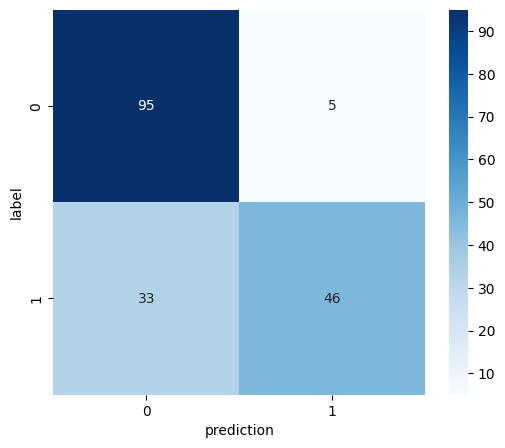

In [47]:
with mlflow.start_run() as run2:
    xgb.fit(X_train,Y_train)
    predicted_quantities = xgb.predict(X_test)

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("learning rate", max_depth)
    mlflow.log_param("colsample_bytree",colsample_bytree)
    mlflow.log_param("Gamma",gamma)

    (accuracy,precision,recall,f1,roc) = eval_metrics(Y_test,predicted_quantities)

    mlflow.log_metric("Accuracy",accuracy)
    mlflow.log_metric("Precision",precision)
    mlflow.log_metric("Recall",recall)
    mlflow.log_metric("F1 score",f1)
    mlflow.log_metric("AUC score",roc)

    clsf_report = pd.DataFrame(classification_report(Y_test, predicted_quantities, output_dict=True)).transpose()
    clsf_report.to_csv(r'visualization\classification_report.csv', index=True)
    mlflow.log_artifact(r'visualization\classification_report.csv')

    confusion_matrix = pd.crosstab(Y_test, predicted_quantities, rownames=['label'], colnames=['prediction'])
    plt.figure(figsize=(6,5))

    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='d')
    plt.savefig(r"visualization\confusion_matrix.png")
    mlflow.log_artifact(r"visualization\confusion_matrix.png") 

    client = mlflow.tracking.MlflowClient()
    run_id = mlflow.active_run().info.run_id

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    print(tracking_url_type_store)
    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(xgb, "model", registered_model_name="Titanic_model")
        print("completed")
    else:
        mlflow.sklearn.log_model(xgb)    

### Explore the Model Registry API Workflow

When a new model version is created with the MLflow Model Registry's Python APIs, the name and version information is printed for future reference. You can also navigate to the MLflow Model Registry UI to view the new model version. 

Define the new model version as a variable in the cell below.

In [48]:
model_version = 2

### Add a description to the new model version manually

In [49]:
from mlflow.tracking.client import MlflowClient

client = MlflowClient()
client.update_model_version(
  name=model_name,
  version=model_version,
  description="This is the best model version. It's a xboost model"
)

<ModelVersion: creation_timestamp=1652087217579, current_stage='None', description="This is the best model version. It's a xboost model", last_updated_timestamp=1652087483463, name='Titanic_model', run_id='1c949f975bbe45ef95d0c9be32188a8b', run_link=None, source='./mlruns/0/1c949f975bbe45ef95d0c9be32188a8b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

### Load new version (Xgboost model)

In [51]:
import mlflow.pyfunc
model_name = "Titanic_model"
model_version_uri = "models:/{model_name}/2".format(model_name=model_name)
print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
model_version_2 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/Titanic_model/2'


In [52]:
results = model_version_2.predict(pd.DataFrame(X_test))
accuracy  = accuracy_score(Y_test,results)
print("Accuracy Obtained in production:",accuracy
)

Accuracy Obtained in production: 0.7877094972067039
